<a href="https://colab.research.google.com/github/jvataidee/PesquisaOperacional/blob/master/cadeias_de_markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cadeias de Markov com Python
---

O presente modelo é um estudo didático referente a disciplina de Cadeias de Markov do curso do MBA de Pesquisa Operacional e Tomada de Decisão da BsBR.

Como caso de estudo iremos realizar a criação de um modelo para identifica sequência de eventos mais prováveis de acontecer no treinamento de um modelo de Deep Learning, tendo o foco final colocar esse modelo em Produção.



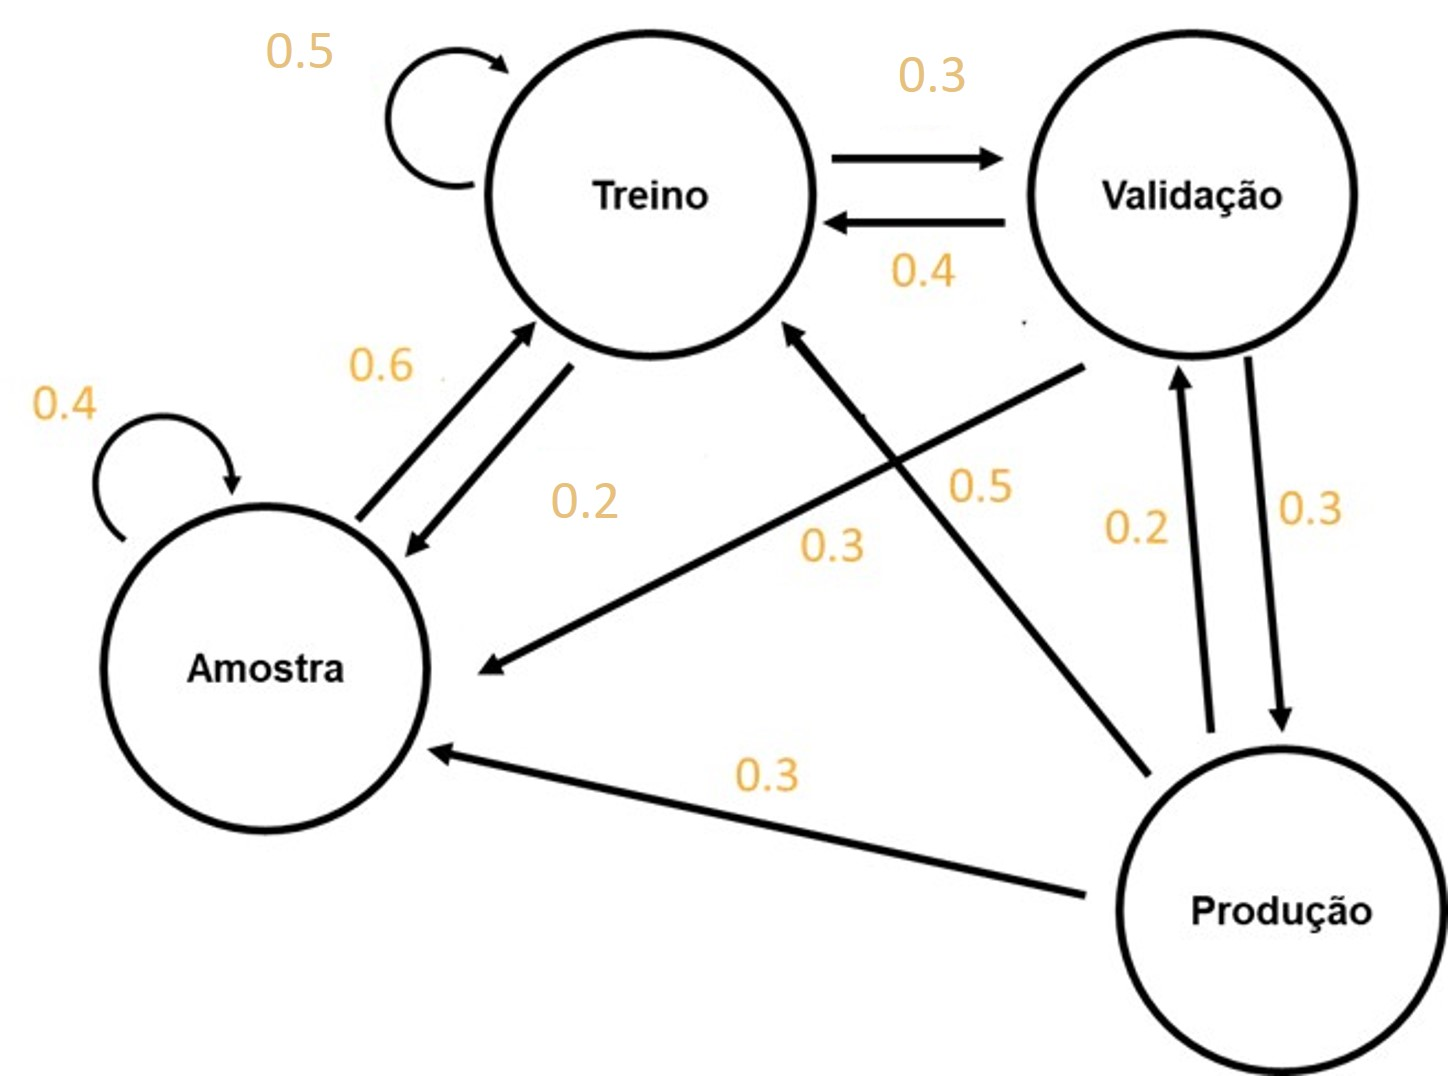

In [39]:
#importando as bibliotecas
import numpy as np
import random as rm
import pandas as pd
import matplotlib.pyplot as plt

Os dados probabilísticos aqui foram analisando em conjunto com cientistas de dados, avaliando de forma subjetiva como e qual a sequência específicas de eventos nos treinamentos dos seus modelos de deep learning.

In [40]:
#lista de estados
estados_desenvolvimento = ["Amostra", "Treino", "Validação","Produção"]

#Matriz de estado mudancas
sequencias = [["Amostra -> Amostra", "Amostra -> Treino", "Amostra -> Validação", "Amostra -> Produção"],
              ["Treino -> Amostra", "Treino -> Treino", "Treino -> Validação", "Treino -> Produção"],
              ["Validação -> Amostra", "Validação -> Treino", "Validação -> Validação", "Validação -> Produção"],
              ["Produção -> Amostra", "Produção -> Treino", "Produção -> Validação", "Produção -> Produção"]]


#Matriz de estado
prob_sequencia = [[0.4, 0.6, 0.0, 0.0],
                  [0.2, 0.5, 0.3, 0.0],
                  [0.3, 0.4, 0.0, 0.3],
                  [0.3, 0.5, 0.2, 0.0]]

In [41]:
for idex, value in enumerate(sequencias):
    print(value[0], "Prob:", prob_sequencia[idex][0])
    print(value[1], "Prob:", prob_sequencia[idex][1])
    print(value[2], "Prob:", prob_sequencia[idex][2])
    print(value[3], "Prob:", prob_sequencia[idex][3])

    print("Probabilidade Total", prob_sequencia[idex][0]+prob_sequencia[idex][1]+prob_sequencia[idex][2]+prob_sequencia[idex][3], "\n")

Amostra -> Amostra Prob: 0.4
Amostra -> Treino Prob: 0.6
Amostra -> Validação Prob: 0.0
Amostra -> Produção Prob: 0.0
Probabilidade Total 1.0 

Treino -> Amostra Prob: 0.2
Treino -> Treino Prob: 0.5
Treino -> Validação Prob: 0.3
Treino -> Produção Prob: 0.0
Probabilidade Total 1.0 

Validação -> Amostra Prob: 0.3
Validação -> Treino Prob: 0.4
Validação -> Validação Prob: 0.0
Validação -> Produção Prob: 0.3
Probabilidade Total 1.0 

Produção -> Amostra Prob: 0.3
Produção -> Treino Prob: 0.5
Produção -> Validação Prob: 0.2
Produção -> Produção Prob: 0.0
Probabilidade Total 1.0 



## Crindo script

In [42]:
#Criando classe de Markov
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in range(len(self.states))}
        self.states_dict = {index: self.states[index] for index in range(len(self.states))}

    #Definir função do estado futuro
    def next_state(self,current_state):
        return np.random.choice( self.states,
            p = self.transition_matrix[self.index_dict[current_state], :])

    #Gerar estados d problema
    def generate_states(self, current_state, no = 10):
        future_states = []

        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state

        return future_states

    def generate_especific_states(self, current_state, stop_state):
        future_states = []
        i = 1
        while current_state != stop_state:
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
            i += 1

        return future_states

    def generate_simulation(self, current_state, stop_state, sm = 10):
        n_estados = []
        resultado_sim = []

        for i in range(sm):
            resultado = self.generate_especific_states(current_state, stop_state)
            n_estados.append(len(resultado)+1)
            resultado_sim.append(resultado)

        return n_estados, resultado_sim


    def generate_risc(self, current_state, stop_state, nn = 3, nm = 20, sm = 10):
        erro = 0
        nerro = 0

        resultado = self.generate_simulation(current_state, stop_state, sm)

        for i in range(len(resultado[1])):
            if len(resultado[1][i]) < nn:
                erro += 1
            elif len(resultado[1][i]) > nm:
                erro += 1
            else:
                nerro += 1
        
        p_erro = (erro/sm)*100
        p_nerro = (nerro/sm)*100

        return resultado, erro, nerro, p_erro, p_nerro


In [43]:
atividades_modelo = MarkovChain(transition_matrix = prob_sequencia,
                                states = estados_desenvolvimento)

In [44]:
#Definindo estados atual e futuro
estato_atual = 'Amostra'
estato_futuro = 'Produção'

## Proximo estado

In [45]:
atividades_modelo.next_state(current_state = estato_atual)

'Treino'

In [58]:
simulacoes = 1000000

resultado = []
for i in range(simulacoes):
    resultado.append(atividades_modelo.next_state(current_state = estato_atual))

In [59]:
resultado_count = pd.DataFrame(resultado).value_counts()
resultado_count

Treino     600080
Amostra    399920
dtype: int64

In [64]:
round(resultado_count[0]/simulacoes *100,0)

60.0

In [65]:
round(resultado_count[1]/simulacoes *100,0)

40.0

## Gerando estados futuros

## Simulando
Na simulação, vamos considerar que cada evento ocorre em uma semana, com isso, realizando diversas simulações dos eventos e dos estados podemos etimar a quantidade de semanas que demandaria para realizar um treinamento de um modelo.

In [47]:
numero_semanas  = 10
resultado = atividades_modelo.generate_states(current_state = estato_atual, no = numero_semanas)
resultado

['Treino',
 'Validação',
 'Treino',
 'Validação',
 'Treino',
 'Amostra',
 'Treino',
 'Treino',
 'Validação',
 'Amostra']

In [48]:
resultado_count = pd.DataFrame(resultado).value_counts()
resultado_count

Treino       5
Validação    3
Amostra      2
dtype: int64

## Parando em um estado específico

In [49]:
resultado = atividades_modelo.generate_especific_states(current_state = estato_atual,
                                                        stop_state = estato_futuro )
resultado

['Treino',
 'Amostra',
 'Treino',
 'Treino',
 'Amostra',
 'Treino',
 'Validação',
 'Amostra',
 'Treino',
 'Treino',
 'Amostra',
 'Treino',
 'Amostra',
 'Treino',
 'Treino',
 'Amostra',
 'Amostra',
 'Amostra',
 'Treino',
 'Treino',
 'Treino',
 'Treino',
 'Amostra',
 'Treino',
 'Amostra',
 'Amostra',
 'Amostra',
 'Treino',
 'Treino',
 'Treino',
 'Treino',
 'Validação',
 'Produção']

## Simulação até estado específico

In [50]:
simulacoes = 300

resultado = atividades_modelo.generate_simulation(current_state = estato_atual,
                                                  stop_state = estato_futuro,
                                                  sm = simulacoes )

In [51]:
#Transformando em dataframe
resultado_df  = pd.DataFrame()
resultado_df["Semanas"] = resultado[0]
resultado_df["Resultado"] = resultado[1]
resultado_df["Simulacao"] = 0

simulacao = []
for i in range(len(resultado_df["Resultado"])):
    simulacao.append(i+1)

resultado_df["Simulacao"] = simulacao

In [52]:
resultado_df.head()

,Semanas,Resultado,Simulacao
0,15,"[Amostra, Treino, Amostra, Treino, Treino, Val...",1
1,28,"[Treino, Treino, Treino, Treino, Treino, Valid...",2
2,20,"[Amostra, Amostra, Amostra, Treino, Treino, Am...",3
3,6,"[Amostra, Treino, Treino, Validação, Produção]",4
4,11,"[Amostra, Amostra, Treino, Validação, Treino, ...",5


In [53]:
resultado_df["Média Semanas"] = np.mean(resultado_df["Semanas"])
resultado_df["Média Semanas"][0] 

20.986666666666668

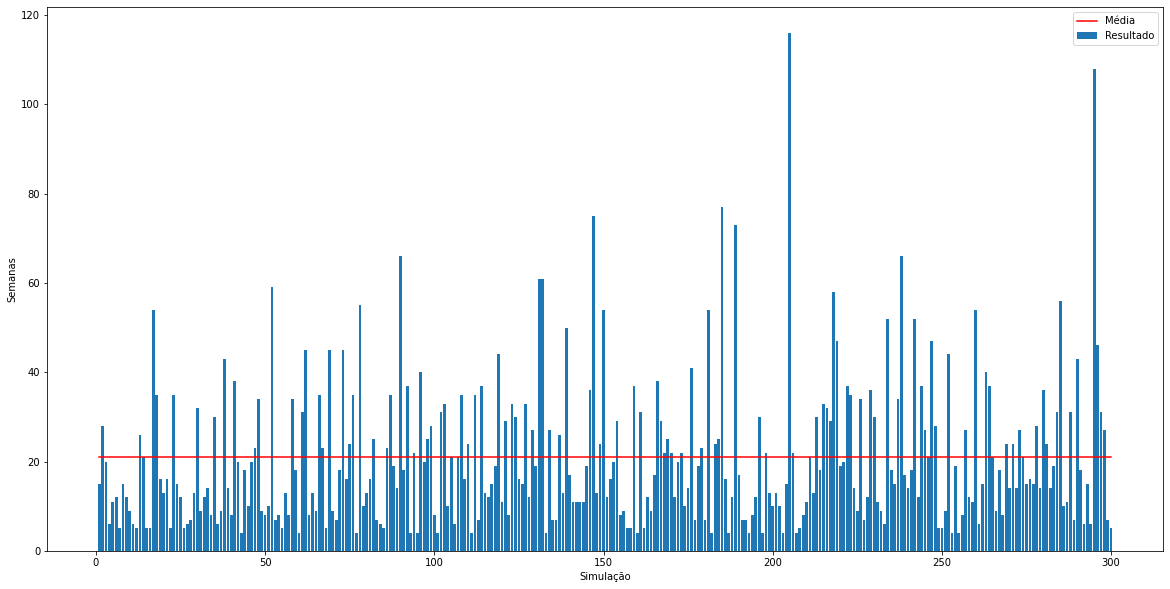

In [54]:
plt.figure(figsize=(20,10)) 
plt.bar(resultado_df["Simulacao"],resultado_df["Semanas"], label = "Resultado")
plt.plot(resultado_df["Simulacao"],resultado_df["Média Semanas"], label = "Média", color = 'r')
plt.xlabel("Simulação")
plt.ylabel("Semanas")
plt.legend()
plt.show();

## Avaliando provavél situação e risco

In [55]:
simulacoes = 300
semana_maxima = 16
semana_min = 4

resultado = atividades_modelo.generate_risc(current_state = estato_atual,
                                            stop_state = estato_futuro,
                                            nn = semana_min, nm = semana_maxima,
                                            sm = simulacoes )

In [56]:
print(f"Dá Errado {round(resultado[3],2)} % \nDá Certo {round(resultado[4],2)} %")

Dá Errado 52.67 % 
Dá Certo 47.33 %
